In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import pickle
import scipy
import time
import torch

from scipy.stats import binom, binom_test, wilcoxon
from tensorflow import keras

import sbibm

from sbibm.tasks.ddm.utils import LinearCollapseDDM
from sbibm.utils.io import get_tensor_from_csv, get_ndarray_from_csv
from sbi.analysis import pairplot
from utils import compile_df, huber_loss, mean_squared_error

In [2]:
# Plotting settings
plt.style.use('plotting_settings.mplstyle')
# Colorblind color palette
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# Fix seed for figures.
seed = 223174 #torch.randint(1000000, (1,))
torch.manual_seed(seed)
print(f"seed {seed}")

seed 223174


In [3]:
task = sbibm.get_task("ddm")
prior = task.get_prior_dist()
simulator = task.get_simulator(seed=seed) # Passing the seed to Julia.

## Load inference results

In [4]:
with open("../data/results/linearcollapseDDM_100runs.p", "rb") as fh:
    # thos contains gt parameters
    # xos the corresponding observed data
    # samples the inferred posterior samples
    thos, xos, samples, mm, prior, transforms = pickle.load(fh).values()

In [5]:
limits = [[prior.base_dist.low[i], prior.base_dist.high[i]] for i in range(len(prior.base_dist.low))]

In [6]:
# limits= [[-2.5, 2.5], [0.5, 2.0], [.25, .75], [.05, .95], [-2, 0]]
labels = [r"$v$", r"$a$", r"$w$", r"$\tau$", r"$\gamma$"]

### Calculate SBC ranks under inferred posteriors

In [7]:
N, num_params = thos.shape
L = 1000 # number of SBC samples from posterior

ranks = np.zeros((N, num_params))

for obsi in range(N):
    # rank tho under samples
    ranks[obsi, :] = (samples[obsi][:L,:] < thos[obsi,]).sum(0)

### Define simulator for predictive checks

In [8]:
ddm = LinearCollapseDDM()

# Generate data full ddm
def simulator(theta):
    v, a, w, ndt, gamma = theta.numpy().T
    # using boundary separation a and offset w
    # pass negative lower bound as required by DiffModels.
    bl = -w * a
    bu = (1 - w) * a

    rts, choices = ddm.simulate(v, bu, -bl, gamma)
    rts += ndt.reshape(-1, 1)
    # encode zero choices as negative RTs.
    rts[choices == 0] *= -1

    return torch.tensor(rts, dtype=torch.float32)

/home/janfb/.local/lib/python3.7/site-packages/julia/core.py:691: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  FutureWarning,


In [9]:
# Select one index from the 100 posteriors for good visualization
pii = 8

posterior_samples = samples[pii]
prior_samples = prior.sample((10000,))

prior_predictive_samples = simulator(prior_samples)
posterior_predictive_samples = simulator(posterior_samples)
true_params_samples = simulator(thos[pii].repeat(posterior_samples.shape[0], 1))

/home/janfb/qode/sbi/sbi/utils/plot.py:364: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/utils/plot.py:364: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/utils/plot.py:364: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/utils/plot.py:364: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/utils/plot.py:364: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/utils/plot.py:364: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/utils/plot.py:364: UserWarning: No contour levels were fo

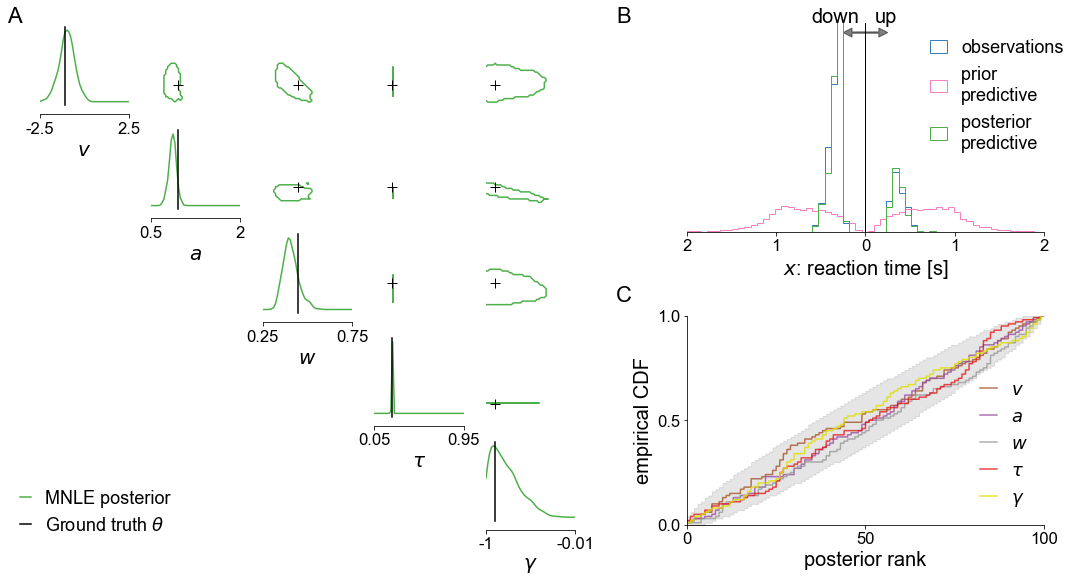

In [10]:
fig = plt.figure(figsize=(18, 9))
outer_grid = fig.add_gridspec(1, 2, wspace=0.25, hspace=0, width_ratios=[.6, .4])
# Plotting settings
notch = True
density = True
nbins = 100
histtype = "step"
repeats = 50

# posterior samples
num_plots = 5
inner_grid = outer_grid[0, 0].subgridspec(num_plots, num_plots, wspace=0.25, hspace=0.2)
ax1 = inner_grid.subplots()  # Create all subplots for the inner grid.
pairplot(samples[pii], 
         points=thos[pii], 
         limits=limits, 
         ticks =limits, 
         samples_colors=colors[2:3], 
         diag="kde",
         upper="contour",
         kde_offdiag=dict(bw_method="scott", bins=50),
         contour_offdiag=dict(levels=[0.95], percentile=True),
         points_offdiag=dict(marker="+", markersize=10), 
         points_colors=["k"], 
         fig=fig, 
         axes=ax1,
         labels=labels,
        );
plt.sca(ax1[0, 0])
plt.legend(["MNLE posterior", r"Ground truth $\theta$", ],
           bbox_to_anchor=(-.4, -4.2), handlelength=0.6, 
           loc=2)

# posterior metrics
inner_grid = outer_grid[0, 1].subgridspec(2, 1, wspace=0, hspace=.4, )
ax2 = inner_grid.subplots()  # Create all subplots for the inner grid.

## PREDICTIVES
plt.sca(ax2[0])
_, bins = np.histogram(prior_predictive_samples.numpy(), bins=nbins)
plt.hist(true_params_samples.numpy(), bins=bins, 
          density=density, histtype=histtype, color=colors[0])
plt.hist(prior_predictive_samples.numpy(), bins=nbins, alpha=1, 
                      density=density, histtype=histtype, color=colors[3]);
plt.hist(posterior_predictive_samples.numpy(), bins=bins, alpha=1, 
         density=density, histtype=histtype, color=colors[2])
ax2[0].spines['left'].set_visible(False)
plt.yticks([])
plt.xlabel("$x$: reaction time [s]")
ticks = np.array([-2, -1, 0, 1, 2])
plt.xticks(ticks, abs(ticks))
plt.xlim([ticks.min(), ticks.max()])
plt.legend(["observations", "prior \npredictive", "posterior \npredictive"], loc=1, handlelength=0.9, 
           bbox_to_anchor=(1.1, 1.0),
          )

# Arrows
plt.axvline(0, color="k", lw=1)
y = 4.4
length = 0.15
plt.arrow(0, y, length, 0., width=0.03, 
          head_width=.2, head_length=0.1, 
          color="k", alpha=0.5)
plt.arrow(0, y, -length, 0., width=0.03, 
          head_width=.2, head_length=0.1, 
          color="k", alpha=0.5)

plt.text(0.1, 1.05*y, s="up")
plt.text(-.6, 1.05*y, s="down")
plt.ylim([0, 1.05*y])

## SBC
plt.sca(ax2[1])
color_offset = 4
for jj in range(num_params):
    hist, *_ = np.histogram(ranks[:, jj], bins=nbins, density=False)
    histcs = hist.cumsum()
    plt.plot(np.linspace(0, nbins, repeats*nbins), 
             np.repeat(histcs / histcs.max(), repeats), 
             label=labels[jj], 
             color=colors[jj+color_offset], 
             alpha=0.8)
    plt.yticks(np.linspace(0, 1, 3))
    plt.ylabel("empirical CDF")
    plt.legend(loc=4, handlelength=0.9)
    plt.ylim(0, 1)
    plt.xlim(0, nbins)
    plt.xticks(np.linspace(0, nbins, 3))
    plt.xlabel("posterior rank")
    # Construct uniform histogram.
    if jj==0:
        hb = binom(N, p=1 / nbins).ppf(0.5) * np.ones(nbins)
        hbb = hb.cumsum() / hb.sum()

        lower = [binom(N, p=p).ppf(0.005) for p in hbb]
        upper = [binom(N, p=p).ppf(0.995) for p in hbb]

        # Plot grey area with expected ECDF.
        plt.fill_between(x=np.linspace(0, nbins, repeats*nbins), 
                     y1=np.repeat(lower / np.max(lower), repeats), 
                     y2=np.repeat(upper / np.max(lower), repeats), 
                     color="grey", 
                     alpha=0.2)


weight = "regular"
fontsize = 22
y1 = 0.9
x1 = 0.1
dx = 0.47
fig.text(x1, y1, "A", fontsize=fontsize, fontweight=weight)
fig.text(x1 + dx, y1, "B", fontsize=fontsize, fontweight=weight)
fig.text(x1 + dx, y1-.43, "C", fontsize=fontsize, fontweight=weight)

plt.tight_layout();
fig.savefig("figures/Figure5-MNLE-LinearCollapseDDM-Posterior.png", dpi=300, bbox_inches="tight");